In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score
import numpy as np
from sklearn.metrics import make_scorer
f1_score = make_scorer(f1_score)

In [2]:
#import data
Data=pd.read_csv("Halifax-Transfomed-Data-BS-NoBreak.csv")

In [3]:
X = Data.iloc[:,:-1]
y = Data.iloc[:,-1]

In [4]:
#split test and training set. 
np.random.seed(60)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 1000)

In [5]:
#Define estimator and model
classifiers = {}
classifiers.update({"XGBoost": XGBClassifier(random_state=1000,eval_metric=f1_score,use_label_encoder=False)})

In [6]:
#Define range of hyperparameters for estimator
np.random.seed(60)
parameters = {}
parameters.update({"XGBoost": {"classifier__eta":[0.001,0.01,0.02,0.1,0.25,0.5,1],
                                    "classifier__alpha":[0.001,0.01,0.02,0.1],
                                     "classifier__min_child_weight" : [0.001,0.01,0.02,0.1],
                                    "classifier__lambda" :[0.001,0.01,0.02,0.1],
                                     "classifier__gamma" :[0.001,0.01,0.02,0.1,0.25,0.5,1],
                                     #"classifier__max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1920]
                                    
}})


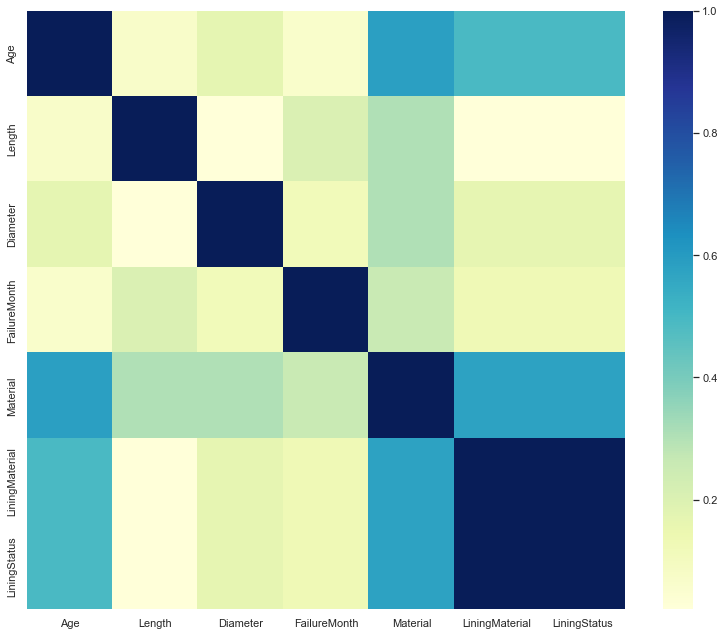

In [7]:
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

In [8]:
X_train

,Age,Length,Diameter,FailureMonth,Material,LiningMaterial
16458,52,301.797059,150,10.102326,7.548145,2.999270
13565,44,565.384319,200,10.102326,7.548145,2.999270
13900,43,173.668724,150,10.102326,7.548145,0.999603
14416,26,114.807520,150,7.758532,7.548145,0.999603
6231,23,2.753933,300,7.758532,2.877769,0.999603
...,...,...,...,...,...,...
15611,52,105.583438,150,6.806185,7.548145,2.999270
3776,39,0.944274,400,3.138389,2.877769,0.999603
6215,18,2.301865,300,3.799472,2.877769,0.999603
4695,25,0.508127,50,4.861834,2.877769,0.999603


In [9]:
FEATURE_IMPORTANCE = {"XGBoost"}
selected_classifier = "XGBoost"
classifier = classifiers[selected_classifier]

In [10]:
scaler = StandardScaler()
steps = [("scaler", scaler), ("classifier", classifier)]
pipeline = Pipeline(steps = steps)

In [11]:
#Define parameters that we want to use in gridsearch cv
param_grid = parameters[selected_classifier]

In [12]:
# Initialize gridsearchCV object for estimator
gscv =RandomizedSearchCV(pipeline, param_grid, cv = 3, n_jobs=-1, verbose = 3, scoring = f1_score, n_iter =10)

In [13]:
# Fit gscv (Tunes estimator)
print(f"Now tuning {selected_classifier}. Go grab a beer or something.")
gscv.fit(X_train, np.ravel(y_train))  

Now tuning XGBoost. Go grab a beer or something.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   12.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.6s finished


[17:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            eval_metric=make_scorer(f1_score),
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,
                               

In [14]:
#Getting the best hyperparameters
best_params = gscv.best_params_
best_params

{'classifier__min_child_weight': 0.1,
 'classifier__lambda': 0.001,
 'classifier__gamma': 0.01,
 'classifier__eta': 0.5,
 'classifier__alpha': 0.02}

In [15]:
#Getting the best score of model
best_score = gscv.best_score_
best_score

0.9164706761193625

In [16]:
#Check overfitting of the estimator
from sklearn.model_selection import cross_val_score
mod = XGBClassifier(alpha=0.02,
                    eta= 0.5,
                    gamma= 0.01,
                    reg_lambda=0.001,
                     #max_Depth=7,
                    min_child_weight=0.1,
                    eval_metric='mlogloss',
                    random_state=10000)

scores_test = cross_val_score(mod, X_test, y_test, scoring='f1', cv=5)

scores_test

c:\users\sgharaa\desktop\sample_project2\env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([0.91022965, 0.90792291, 0.88284519, 0.90376569, 0.91286307])

In [17]:
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

XGBClassifier(alpha=0.02, base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.5,
              eval_metric=make_scorer(f1_score), gamma=0.01, gpu_id=None,
              importance_type=None, interaction_constraints=None, lambda=0.001,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1000, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, ...)

In [18]:
#Find f1 score of the model with all features (Model is tuned for all features)
results={}
model=classifier.set_params(alpha=0.02,
                    eta= 0.5,
                    gamma= 0.01,
                    reg_lambda=0.001,
                     #max_Depth=7,
                    min_child_weight=0.1,
                    eval_metric='mlogloss',
                    random_state=10000)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
F1 = metrics.f1_score(y_test, y_pred)
results = {"classifier": model,
              "Best Parameters": best_params,
              "Training f1": best_score*100,
              "Test f1": F1*100}
results

{'classifier': XGBClassifier(alpha=0.02, base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eta=0.5, eval_metric='mlogloss', gamma=0.01, gpu_id=-1,
               importance_type=None, interaction_constraints='', lambda=0.001,
               learning_rate=0.5, max_delta_step=0, max_depth=6,
               min_child_weight=0.1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
               random_state=10000, reg_alpha=0.0199999996, reg_lambda=0.001,
               scale_pos_weight=1, subsample=1, tree_method='exact', ...),
 'Best Parameters': {'classifier__min_child_weight': 0.1,
  'classifier__lambda': 0.001,
  'classifier__gamma': 0.01,
  'classifier__eta': 0.5,
  'classifier__alpha': 0.02},
 'Training f1': 91.64706761193625,
 'Test f1': 92.06081081081082}

In [19]:
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [20]:
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)
np.random.seed(60)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, verbose = 3)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


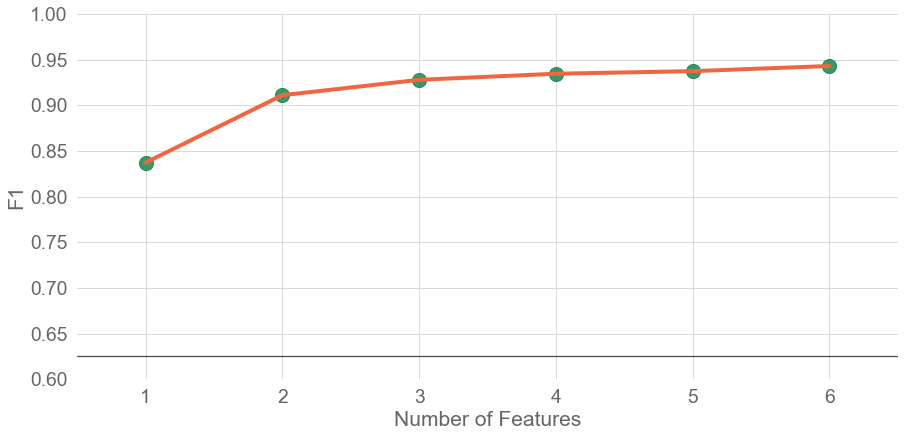

In [21]:
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "F1": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "F1", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["F1"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.60, 1)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

In [22]:
#Define new training and test set based based on selected features by RFECV
X_train_rfecv = X_train[selected_features]
X_test_rfecv= X_test[selected_features]

In [23]:
np.random.seed(60)
classifier.fit(X_train_rfecv, np.ravel(y_train))

XGBClassifier(alpha=0.02, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.5, eval_metric='mlogloss', gamma=0.01, gpu_id=-1,
              importance_type=None, interaction_constraints='', lambda=0.001,
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=0.1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=10000, reg_alpha=0.0199999996, reg_lambda=0.001,
              scale_pos_weight=1, subsample=1, tree_method='exact', ...)

In [24]:
#Finding important features
np.random.seed(60)
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)
feature_importance

,Feature Label,Feature Importance
4,Material,0.821959
1,Length,0.051088
0,Age,0.041924
3,FailureMonth,0.029891
5,LiningMaterial,0.028205
2,Diameter,0.026934


In [25]:
# Initialize GridSearch object for model with selected features
np.random.seed(60)
gscv = RandomizedSearchCV(pipeline, param_grid, cv = 3,  n_jobs= -1, verbose = 3, scoring = f1_score, n_iter=50)

In [26]:
#Tuning random forest classifier with selected features 
np.random.seed(60)
gscv.fit(X_train_rfecv,y_train) 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   58.1s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              XGBClassifier(alpha=0.02,
                                                            base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            enable_categorical=False,
                                                            eta=0.5,
                                                            eval_metric='mlogloss',
                                                            gamma=0.01,
                                                            gp

In [27]:
#Getting the best parameters of model with selected features
best_params = gscv.best_params_
best_params

{'classifier__min_child_weight': 0.1,
 'classifier__lambda': 0.001,
 'classifier__gamma': 0.01,
 'classifier__eta': 0.25,
 'classifier__alpha': 0.01}

In [28]:
#Getting the score of model with selected features
best_score = gscv.best_score_
best_score

0.9164706761193625

In [29]:
#Check overfitting of the  tuned model with selected features 
from sklearn.model_selection import cross_val_score
mod = XGBClassifier(alpha=0.01, 
                    eta=0.25,
                    gamma=0.01,
                    reg_lambda=0.001,
                    #max_depth=4,
                    min_child_weight=0.1,
                    eval_metric='mlogloss',
                    random_state=10000)

scores_test = cross_val_score(mod, X_test_rfecv, y_test, scoring='f1', cv=5)

scores_test

c:\users\sgharaa\desktop\sample_project2\env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([0.91631799, 0.91182796, 0.9044586 , 0.90677966, 0.92857143])

In [30]:
results={}
model=classifier.set_params(alpha=0.01, 
                    eta=0.25,
                    gamma=0.01,
                    reg_lambda=0.001,
                    #max_depth=4,
                    min_child_weight=0.1,
                    eval_metric='mlogloss',
                    random_state=10000)
model.fit(X_train_rfecv,y_train)
y_pred = model.predict(X_test_rfecv)
F1 = metrics.f1_score(y_test, y_pred)
results = {"classifier": model,
              "Best Parameters": best_params,
              "Training f1": best_score*100,
              "Test f1": F1*100}
results

{'classifier': XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eta=0.25, eval_metric='mlogloss', gamma=0.01, gpu_id=-1,
               importance_type=None, interaction_constraints='', lambda=0.001,
               learning_rate=0.5, max_delta_step=0, max_depth=6,
               min_child_weight=0.1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
               random_state=10000, reg_alpha=0.0199999996, reg_lambda=0.001,
               scale_pos_weight=1, subsample=1, tree_method='exact', ...),
 'Best Parameters': {'classifier__min_child_weight': 0.1,
  'classifier__lambda': 0.001,
  'classifier__gamma': 0.01,
  'classifier__eta': 0.25,
  'classifier__alpha': 0.01},
 'Training f1': 91.64706761193625,
 'Test f1': 92.06081081081082}